# Model Comparison & Selection

## Decision rule
- Evaluate every model **at the VAL-chosen threshold** computed to meet a **recall floor = 0.90**.  
- If a model cannot reach the floor on VAL, flag it as **fails floor**.
- Among models that meet the floor, **prefer higher Precision** on TEST.
- If still tied, break ties by **F1**, then **AP (PR-AUC)**.
- Keep comparison fair by using the **same VAL-derived threshold** when scoring TEST.


In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import json, numpy as np, pandas as pd
from sklearn.metrics import (
    precision_recall_curve, precision_recall_fscore_support, accuracy_score,
    confusion_matrix, average_precision_score, roc_auc_score
)


In [ ]:
try:
    ARTIFACTS
except NameError:
    from google.colab import drive
    drive.mount("/content/drive")
    CANDIDATES = [
        Path("/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project"),
        Path("/content/drive/masters_math/capestone/Final_project/Final_project"),
    ]
    PROJECT_ROOT = next((p for p in CANDIDATES if (p/"src"/"utilities.py").exists()), None)
    assert PROJECT_ROOT, "Could not find project root. Check Drive path."
    ARTIFACTS = PROJECT_ROOT/"artifacts"

Mounted at /content/drive


In [ ]:
RECALL_FLOOR = 0.90

def read_preds_any(path: Path):
    df = pd.read_csv(path)
    y_col = "y_true" if "y_true" in df.columns else ("label" if "label" in df.columns else None)
    assert y_col is not None, f"No y_true or label in {path.name}"
    y = df[y_col].astype(int).to_numpy()
    if "y_score" in df.columns:
        s = df["y_score"].to_numpy()
    else:
        prob_cols = [c for c in df.columns if c.startswith("prob_")]
        assert len(prob_cols) == 1, f"Need exactly one prob_* column in {path.name}"
        s = df[prob_cols[0]].to_numpy()
    return y, s

def read_threshold_json(thr_path: Path) -> float:
    blob = json.loads(thr_path.read_text())
    for k in ["best_threshold", "best_thr", "threshold"]:
        if k in blob:
            return float(blob[k])
    raise KeyError(f"No threshold key in {thr_path}")

def pick_thr_with_recall_floor(y_val, s_val, floor=RECALL_FLOOR):
    p, r, t = precision_recall_curve(y_val, s_val)
    idx = np.where(r >= float(floor))[0]
    if len(idx) == 0:
        return None, {"meets_floor": False}
    cands = []
    for i in idx:
        thr = 0.5 if i == 0 else float(t[i-1])
        P, R = float(p[i]), float(r[i])
        F1 = 0.0 if (P+R)==0 else 2*P*R/(P+R)
        cands.append((P, F1, thr))
    cands.sort(key=lambda x: (x[0], x[1]), reverse=True)
    bestP, bestF1, bestThr = cands[0]
    return bestThr, {"meets_floor": True, "precision": bestP, "f1": bestF1}

def best_f1_threshold(y_val, s_val):
    p, r, t = precision_recall_curve(y_val, s_val)
    f1 = 2 * p * r / (p + r + 1e-12)
    i = int(np.argmax(f1))
    return 0.5 if i == 0 else float(t[i - 1])

def metrics_at_threshold(y, s, thr):
    yhat = (s >= thr).astype(int)
    P, R, F1, _ = precision_recall_fscore_support(y, yhat, average="binary", zero_division=0)
    acc = accuracy_score(y, yhat)
    tn, fp, fn, tp = confusion_matrix(y, yhat, labels=[0,1]).ravel()
    ap  = average_precision_score(y, s)
    auc = roc_auc_score(y, s)
    return {
        "precision": float(P), "recall": float(R), "f1": float(F1), "accuracy": float(acc),
        "ap": float(ap), "roc_auc": float(auc),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)
    }


## Comparison table

All metrics below are computed **at the validation-chosen threshold** applied on test.


In [ ]:
TRANSFORMERS = {
    "distilbert": ARTIFACTS/"transformers"/"distilbert",
    "biobert":    ARTIFACTS/"transformers"/"biobert",
    "pubmedbert": ARTIFACTS/"transformers"/"pubmedbert",
}
BASELINES = {
    "tfidf_logreg": {
        "val": ARTIFACTS/"baselines"/"tfidf"/"val_probs_lr.csv",
        "test": ARTIFACTS/"baselines"/"tfidf"/"test_probs_lr.csv",
    },
    "tfidf_svm": {
        "val": ARTIFACTS/"baselines"/"tfidf"/"val_probs_svm.csv",
        "test": ARTIFACTS/"baselines"/"tfidf"/"test_probs_svm.csv",
    },
}

rows = []

# transformers saved thresholds
for name, mdir in TRANSFORMERS.items():
    try:
        yv, pv = read_preds_any(mdir/"preds"/"val_probs.csv")
        yt, pt = read_preds_any(mdir/"preds"/"test_probs.csv")
        thr = read_threshold_json(mdir/"thresholds.json")
        mv = metrics_at_threshold(yv, pv, thr)
        mt = metrics_at_threshold(yt, pt, thr)
        rows.append({
            "model": name, "thr": thr,
            "VAL_P": mv["precision"], "VAL_R": mv["recall"], "VAL_F1": mv["f1"], "VAL_AP": mv["ap"], "VAL_AUC": mv["roc_auc"],
            "TEST_P": mt["precision"], "TEST_R": mt["recall"], "TEST_F1": mt["f1"], "TEST_Acc": mt["accuracy"],
            "TEST_AP": mt["ap"], "TEST_AUC": mt["roc_auc"],
            "TEST_TN": mt["tn"], "TEST_FP": mt["fp"], "TEST_FN": mt["fn"], "TEST_TP": mt["tp"],
        })
    except Exception as e:
        print("Skipping", name, ":", e)

# baselines: pick threshold on validation using the same recall-floor rule
for name, paths in BASELINES.items():
    try:
        yv, pv = read_preds_any(paths["val"])
        yt, pt = read_preds_any(paths["test"])
        thr, info = pick_thr_with_recall_floor(yv, pv, floor=RECALL_FLOOR)
        if thr is None:
            thr = best_f1_threshold(yv, pv)# fallback if floor not reachable on validation
            meets_val_floor = False
        else:
            meets_val_floor = True
        mv = metrics_at_threshold(yv, pv, thr)
        mt = metrics_at_threshold(yt, pt, thr)
        rows.append({
            "model": name, "thr": thr, "meets_val_floor": meets_val_floor,
            "VAL_P": mv["precision"], "VAL_R": mv["recall"], "VAL_F1": mv["f1"], "VAL_AP": mv["ap"], "VAL_AUC": mv["roc_auc"],
            "TEST_P": mt["precision"], "TEST_R": mt["recall"], "TEST_F1": mt["f1"], "TEST_Acc": mt["accuracy"],
            "TEST_AP": mt["ap"], "TEST_AUC": mt["roc_auc"],
            "TEST_TN": mt["tn"], "TEST_FP": mt["fp"], "TEST_FN": mt["fn"], "TEST_TP": mt["tp"],
        })
    except Exception as e:
        print("Skipping", name, ":", e)

cmp_df = pd.DataFrame(rows)
if cmp_df.empty:
    raise RuntimeError("No model rows were loaded. Confirm the artifact paths printed in the sanity check cell.")

cmp_df["eligible"] = cmp_df["TEST_R"] >= RECALL_FLOOR
cmp_df = cmp_df.sort_values(["eligible","TEST_P","TEST_F1","TEST_AP"],
                            ascending=[False,False,False,False]).reset_index(drop=True)

with pd.option_context("display.float_format", "{:.3f}".format):
    display(cmp_df[[
        "model","thr","eligible",
        "VAL_P","VAL_R","VAL_F1","VAL_AP","VAL_AUC",
        "TEST_P","TEST_R","TEST_F1","TEST_Acc","TEST_AP","TEST_AUC",
        "TEST_TN","TEST_FP","TEST_FN","TEST_TP"
    ]])

# Save for the report
out_dir = ARTIFACTS/"comparison"
out_dir.mkdir(parents=True, exist_ok=True)
cmp_path = out_dir/"all_models_summary.csv"
cmp_df.to_csv(cmp_path, index=False)
print("Saved to:", cmp_path)


,model,thr,eligible,VAL_P,VAL_R,VAL_F1,VAL_AP,VAL_AUC,TEST_P,TEST_R,TEST_F1,TEST_Acc,TEST_AP,TEST_AUC,TEST_TN,TEST_FP,TEST_FN,TEST_TP
0,biobert,0.777,True,0.837,0.905,0.870,0.936,0.984,0.896,0.900,0.898,0.948,0.946,0.978,4046,149,143,1288
1,pubmedbert,0.876,True,0.832,0.905,0.867,0.927,0.980,0.888,0.908,0.898,0.947,0.948,0.983,4031,164,132,1299
2,tfidf_svm,0.125,True,0.416,0.901,0.570,0.711,0.902,0.498,0.904,0.643,0.744,0.778,0.900,2893,1302,137,1294
3,distilbert,0.548,False,0.769,0.905,0.832,0.901,0.975,0.821,0.890,0.854,0.923,0.923,0.975,3918,277,158,1273
4,tfidf_logreg,0.376,False,0.418,0.901,0.571,0.667,0.887,0.501,0.896,0.643,0.747,0.755,0.891,2918,1277,149,1282


Saved to: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/comparison/all_models_summary.csv


- A model is eligible if its test recall is at least 0.90 when scored at the threshold chosen on validation.
- This enforces our deployment requirement of high recall and keeps the comparison fair by fixing the threshold before looking at test.

### Consistency with individual notebooks
- The ranking matches the earlier notebooks: BioBERT and PubMedBERT are the top two, DistilBERT next, then TF-IDF SVM, then TF-IDF Logistic Regression.
- For DistilBert while recall of .90 was not met on test, its very close and the precision is still a lot higher than the tfidf models.

# BioBERT and PubMedBERT
- Differences are minor and due to rounding and the policy of applying the validation-chosen threshold on test.


In [ ]:
def counts_at_threshold(y, s, thr):
    yhat = (s >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yhat, labels=[0, 1]).ravel()
    return int(tn), int(fp), int(fn), int(tp)

err_rows = []

# Transformers: use saved VAL threshold
for name, mdir in TRANSFORMERS.items():
    try:
        yv, pv = read_preds_any(mdir/"preds"/"val_probs.csv")
        yt, pt = read_preds_any(mdir/"preds"/"test_probs.csv")
        thr = read_threshold_json(mdir/"thresholds.json")
        _, vfp, vfn, _ = counts_at_threshold(yv, pv, thr)
        _, tfp, tfn, _ = counts_at_threshold(yt, pt, thr)
        err_rows.append({"model": name, "VAL_FN": vfn, "VAL_FP": vfp, "TEST_FN": tfn, "TEST_FP": tfp})
    except Exception as e:
        print("Skipping", name, "for err table:", e)

# Baselines: re-pick VAL threshold with recall floor (fallback to best-F1 if needed)
for name, paths in BASELINES.items():
    try:
        yv, pv = read_preds_any(paths["val"])
        yt, pt = read_preds_any(paths["test"])
        thr, info = pick_thr_with_recall_floor(yv, pv, floor=RECALL_FLOOR)
        if thr is None:
            thr = best_f1_threshold(yv, pv)
        _, vfp, vfn, _ = counts_at_threshold(yv, pv, thr)
        _, tfp, tfn, _ = counts_at_threshold(yt, pt, thr)
        err_rows.append({"model": name, "VAL_FN": vfn, "VAL_FP": vfp, "TEST_FN": tfn, "TEST_FP": tfp})
    except Exception as e:
        print("Skipping", name, "for err table:", e)

err = pd.DataFrame(err_rows).set_index("model")


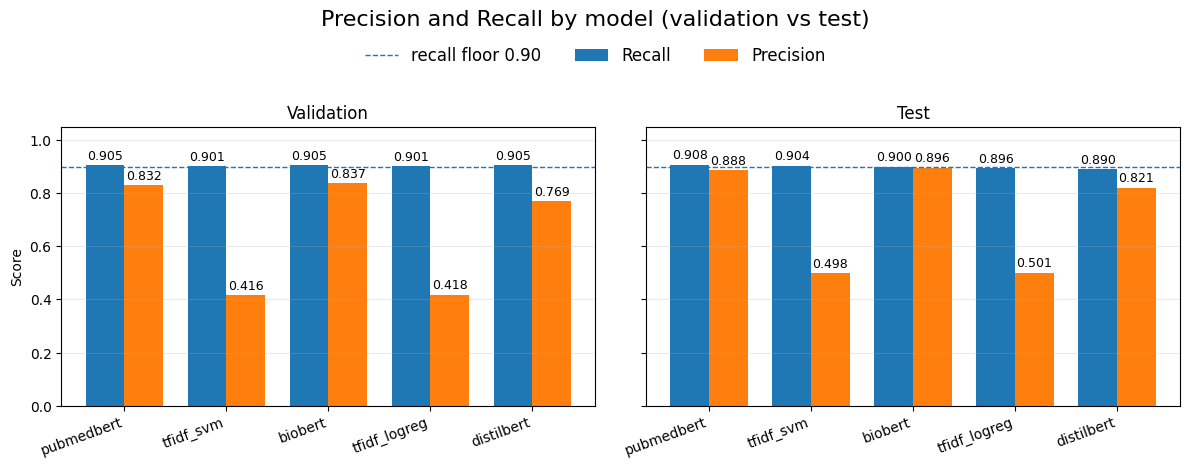

Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/comparison/cmp_precision_recall_bars.png


In [ ]:
OUT_DIR = (PLOTS_DIR if "PLOTS_DIR" in globals() else (Path(ARTIFACTS).parent / "plots")) / "comparison"
OUT_DIR.mkdir(parents=True, exist_ok=True)

df_bar = cmp_df.copy().set_index("model")
order = df_bar.sort_values("TEST_R", ascending=False).index

x = np.arange(len(order))
width = 0.38

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)

# validation
rec_val = df_bar.loc[order, "VAL_R"].values
pre_val = df_bar.loc[order, "VAL_P"].values

axes[0].bar(x - width/2, rec_val, width, label="Recall")
axes[0].bar(x + width/2, pre_val, width, label="Precision")
axes[0].axhline(RECALL_FLOOR, linestyle="--", linewidth=1, label=f"recall floor {RECALL_FLOOR:.2f}")

for i, v in enumerate(rec_val):
    axes[0].text(x[i] - width/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(pre_val):
    axes[0].text(x[i] + width/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

axes[0].set_title("Validation")
axes[0].set_ylabel("Score")
axes[0].set_xticks(x)
axes[0].set_xticklabels(order, rotation=20, ha="right")
axes[0].set_ylim(0, 1.05)
axes[0].grid(axis="y", alpha=0.25)

# test
rec_test = df_bar.loc[order, "TEST_R"].values
pre_test = df_bar.loc[order, "TEST_P"].values

axes[1].bar(x - width/2, rec_test, width)
axes[1].bar(x + width/2, pre_test, width)
axes[1].axhline(RECALL_FLOOR, linestyle="--", linewidth=1)

for i, v in enumerate(rec_test):
    axes[1].text(x[i] - width/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(pre_test):
    axes[1].text(x[i] + width/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

axes[1].set_title("Test")
axes[1].set_xticks(x)
axes[1].set_xticklabels(order, rotation=20, ha="right")
axes[1].set_ylim(0, 1.05)
axes[1].grid(axis="y", alpha=0.25)

# legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False, bbox_to_anchor=(0.5, .98), fontsize=12)

fig.suptitle("Precision and Recall by model (validation vs test)", y=1.03, fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.93])

out_path = OUT_DIR / "cmp_precision_recall_bars.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


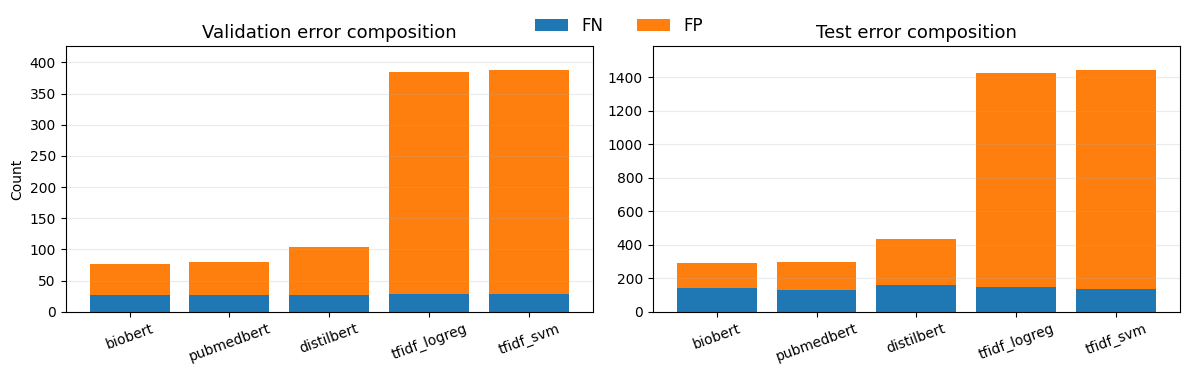

Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/comparison/cmp_error_composition_val_test.png


In [ ]:
order = (
    err.assign(TEST_ERR=lambda d: d["TEST_FN"] + d["TEST_FP"])
       .sort_values("TEST_ERR", ascending=True)
       .index.tolist()
)

val_fn  = err.loc[order, "VAL_FN"].to_numpy()
val_fp  = err.loc[order, "VAL_FP"].to_numpy()
test_fn = err.loc[order, "TEST_FN"].to_numpy()
test_fp = err.loc[order, "TEST_FP"].to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 3.7), sharey=False)

# validation
ax = axes[0]
ax.bar(order, val_fn, label="FN")
ax.bar(order, val_fp, bottom=val_fn, label="FP")
ax.set_title("Validation error composition", fontsize=13)
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=20)
ax.set_ylim(0, 1.10 * (val_fn + val_fp).max())
ax.grid(axis="y", alpha=0.25)

# test
ax = axes[1]
ax.bar(order, test_fn, label="FN")
ax.bar(order, test_fp, bottom=test_fn, label="FP")
ax.set_title("Test error composition", fontsize=13)
ax.tick_params(axis="x", rotation=20)
ax.set_ylim(0, 1.10 * (test_fn + test_fp).max())
ax.grid(axis="y", alpha=0.25)

# legend
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.52, 1.02), fontsize=12)

fig.tight_layout()

out_path = OUT_DIR / "cmp_error_composition_val_test.png"
fig.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)


PubMedBERT vs BioBERT

Recall: 0.908 vs 0.900 (PubMedBERT +0.008)

Precision: 0.888 vs 0.896 (BioBERT +0.008)

Errors: PubMedBERT FN=132, FP=164 | BioBERT FN=143, FP=149

Trade-off: PubMedBERT reduces FN by 11 but adds 15 FP. Choice depends on whether missing an ADE (FN) is costlier than reviewing extra notes.

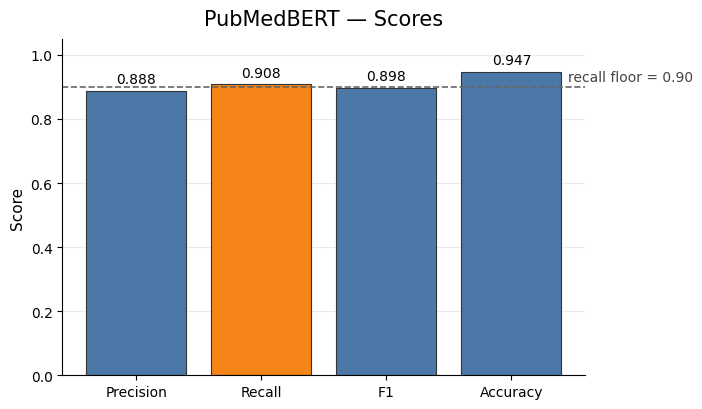

Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/comparison/pubmedbert_test_metrics_bars.png


In [ ]:
PLOTS_DIR = globals().get("PLOTS_DIR", (Path(ARTIFACTS).parent / "plots"))
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

row = cmp_df.loc[cmp_df["model"] == "pubmedbert"].iloc[0]

metrics = {
    "Precision": float(row["TEST_P"]),
    "Recall":    float(row["TEST_R"]),
    "F1":        float(row["TEST_F1"]),
    "Accuracy":  float(row["TEST_Acc"]),
}

fig, ax = plt.subplots(figsize=(7.2, 4.2))

xs = list(metrics.keys())
ys = list(metrics.values())

# colors: highlight Recall, keep others uniform
colors = ["#4C78A8", "#F58518", "#4C78A8", "#4C78A8"]  # recall is orange
bars = ax.bar(xs, ys, color=colors, edgecolor="#333", linewidth=0.8)

# value labels
for b, v in zip(bars, ys):
    xpos = b.get_x() + b.get_width() / 2
    # put labels just above the bar
    ax.text(xpos, v + 0.015, f"{v:.3f}", ha="center", va="bottom", fontsize=10)

# recall floor
ax.axhline(RECALL_FLOOR, linestyle="--", linewidth=1.2, color="#666")
ax.text(
    4.45, RECALL_FLOOR + 0.008, f"recall floor = {RECALL_FLOOR:.2f}",
    ha="right", va="bottom", fontsize=10, color="#444"
)

# extra
ax.set_ylim(0, max(1.05, max(ys) + 0.07))
ax.set_ylabel("Score", fontsize=11)
ax.set_title("PubMedBERT — Scores", fontsize=15, pad=10)
ax.set_axisbelow(True)
ax.grid(axis="y", alpha=0.25)

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

out_path = PLOTS_DIR / "comparison" / "pubmedbert_test_metrics_bars.png"
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_path)